In [1]:
# -------------------------------------------------------------
# This script sets up the Colab environment for interacting with BigQuery and Google Drive.
#
# Purpose:
# - Authenticate the Colab session with Google Cloud services.
# - Initialize the BigQuery client for querying and managing datasets.
# - Mount Google Drive to access project files (e.g., saved CSVs, templates).
# - Load environment variables (such as API keys) securely from a .env file.
#
# Notes:
# - Must run this block at the start of every Colab session.
# - Assumes the .env file is stored at /MyDrive/google/.env.
# - Enables seamless access to BigQuery and external APIs (e.g., Google Places API).
# -------------------------------------------------------------

# %load /content/drive/MyDrive/ColabTemplates/colab_bigquery_startup.txt

# -------------------------------------------------------------
# Authenticate Colab session, initialize BigQuery client, mount Drive.
# -------------------------------------------------------------

!pip install python-dotenv --quiet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Authenticate to Google Cloud
from google.colab import auth
auth.authenticate_user()
print("✅ Colab session authenticated.")

# 2. Initialize BigQuery client
from google.cloud import bigquery
client = bigquery.Client()

# 3. Print authenticated service account
from google.auth import default
creds, _ = default()
try:
    print(f"🔐 Authenticated as: {creds.service_account_email}")
except AttributeError:
    print("🔐 Authenticated, but could not retrieve email.")

# 4. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted.")


✅ Colab session authenticated.
🔐 Authenticated as: default
Mounted at /content/drive
✅ Google Drive mounted.


In [2]:
# === Create RestaurantProfile_WithFlags Table ===
# This cell creates a new BigQuery table called 'RestaurantProfile_WithFlags'
# by adding binary flag columns (is_cafe, is_bar, is_bakery, etc.)
# based on the 'types' field from the original RestaurantProfile table.
# These flags will later be used as features for machine learning models.


from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# SQL to create a new table with flags
query = """
CREATE OR REPLACE TABLE `hygiene-prediction-434.RestaurantModeling.RestaurantProfile_WithFlags` AS
SELECT
  *,
  CASE WHEN 'cafe' IN UNNEST(types) THEN 1 ELSE 0 END AS is_cafe,
  CASE WHEN 'bar' IN UNNEST(types) THEN 1 ELSE 0 END AS is_bar,
  CASE WHEN 'bakery' IN UNNEST(types) THEN 1 ELSE 0 END AS is_bakery,
  CASE WHEN 'meal_takeaway' IN UNNEST(types) THEN 1 ELSE 0 END AS is_meal_takeaway,
  CASE WHEN 'meal_delivery' IN UNNEST(types) THEN 1 ELSE 0 END AS is_meal_delivery,
  CASE WHEN 'night_club' IN UNNEST(types) THEN 1 ELSE 0 END AS is_night_club
FROM
  `hygiene-prediction-434.RestaurantModeling.RestaurantProfile`
"""

# Run the query
query_job = client.query(query)
query_job.result()

print("✅ RestaurantProfile_WithFlags table created successfully with flags.")

✅ RestaurantProfile_WithFlags table created successfully with flags.


In [3]:
# === Create TrainingData Table by Joining Inspections and Restaurant Profiles ===
# This cell creates a new BigQuery table called 'TrainingData'
# by joining the inspection records (InspectionEvents) with restaurant profiles (RestaurantProfile_WithFlags)
# on the 'place_id' key.
# It **filters out** any inspections where place_id is NULL,
# so only valid, matchable restaurants are included for machine learning model development.

from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# SQL query to create the joined TrainingData table
query = """
CREATE OR REPLACE TABLE `hygiene-prediction-434.RestaurantModeling.TrainingData` AS
SELECT
  i.inspection_id,
  i.place_id,
  i.inspection_date,
  i.inspection_type,
  i.result,
  i.violation_codes,
  i.num_violations,
  i.has_critical_violation,
  i.risk,
  r.dba_name,
  r.rating,
  r.price_level,
  r.user_ratings_total,
  r.business_status,
  r.zip,
  r.is_cafe,
  r.is_bar,
  r.is_bakery,
  r.is_meal_takeaway,
  r.is_meal_delivery,
  r.is_night_club
FROM
  `hygiene-prediction-434.RestaurantModeling.InspectionEvents` AS i
LEFT JOIN
  `hygiene-prediction-434.RestaurantModeling.RestaurantProfile_WithFlags` AS r
ON
  i.place_id = r.place_id
WHERE
  i.place_id IS NOT NULL
"""

# Run the query
query_job = client.query(query)
query_job.result()

print("✅ TrainingData table created successfully (place_id NOT NULL).")


✅ TrainingData table created successfully (place_id NOT NULL).


In [4]:

# === Count Rows in TrainingData Table ===
# Quick sanity check to verify the total number of rows after joining inspections and restaurant profiles.

# === Display Schema of TrainingData Table ===
# Prints the column names and types for the TrainingData table to understand available features for modeling.

from google.cloud import bigquery

client = bigquery.Client(project="hygiene-prediction-434")

query = """
SELECT COUNT(*) AS total_rows
FROM `hygiene-prediction-434.RestaurantModeling.TrainingData`
"""

df = client.query(query).to_dataframe()
df

from google.cloud import bigquery

client = bigquery.Client(project="hygiene-prediction-434")

# Fetch schema for the table
table_ref = "hygiene-prediction-434.RestaurantModeling.TrainingData"
table = client.get_table(table_ref)

# Print column names and types
print()
for field in table.schema:
    print(f"{field.name} ({field.field_type})")





,total_rows
0,16169



inspection_id (STRING)
place_id (STRING)
inspection_date (DATE)
inspection_type (STRING)
result (STRING)
violation_codes (STRING)
num_violations (INTEGER)
has_critical_violation (BOOLEAN)
risk (STRING)
dba_name (STRING)
rating (FLOAT)
price_level (INTEGER)
user_ratings_total (INTEGER)
business_status (STRING)
zip (INTEGER)
is_cafe (INTEGER)
is_bar (INTEGER)
is_bakery (INTEGER)
is_meal_takeaway (INTEGER)
is_meal_delivery (INTEGER)
is_night_club (INTEGER)


In [5]:
# ===  Load and Sort Inspections by Place and Date ===
# This cell loads all inspection records from the TrainingData table,
# and sorts them by 'place_id' and 'inspection_date' in ascending order.
# Sorting is necessary to correctly build features based on previous inspections.

from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# SQL to fetch and sort inspections
query = """
SELECT
  *
FROM
  `hygiene-prediction-434.RestaurantModeling.TrainingData`
ORDER BY
  place_id,
  inspection_date
"""

# Load into pandas dataframe
df = client.query(query).to_dataframe()

# === Create Binary Fail Flag for Each Inspection ===
# where 1 = failed inspection, 0 = passed or other outcomes.

df['fail'] = df['result'].apply(lambda x: 1 if x == 'fail' else 0)

print("✅ Created 'fail' flag for each inspection.")
df[['place_id', 'inspection_date', 'result', 'fail']].head(10)

print(f"✅ Loaded {len(df)} inspection records, sorted by place_id and inspection_date.")
df.info()
df.head()


✅ Created 'fail' flag for each inspection.


,place_id,inspection_date,result,fail
0,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,pass,0
1,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,pass,0
2,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,pass,0
3,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,pass,0
4,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,fail,1
5,ChIJ-0L3BegvDogRrtvLYG1UV4A,2024-01-25,pass,0
6,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2022-07-29,pass w conditions,0
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,pass,0
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,fail,1
9,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-19,pass,0


✅ Loaded 16169 inspection records, sorted by place_id and inspection_date.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16169 entries, 0 to 16168
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   inspection_id           16169 non-null  object 
 1   place_id                16169 non-null  object 
 2   inspection_date         16169 non-null  dbdate 
 3   inspection_type         16169 non-null  object 
 4   result                  16169 non-null  object 
 5   violation_codes         16169 non-null  object 
 6   num_violations          16169 non-null  Int64  
 7   has_critical_violation  16169 non-null  boolean
 8   risk                    16169 non-null  object 
 9   dba_name                16169 non-null  object 
 10  rating                  16165 non-null  float64
 11  price_level             14578 non-null  Int64  
 12  user_ratings_total      16165 non-null  Int64  
 13  business_status 

,inspection_id,place_id,inspection_date,inspection_type,result,violation_codes,num_violations,has_critical_violation,risk,dba_name,...,user_ratings_total,business_status,zip,is_cafe,is_bar,is_bakery,is_meal_takeaway,is_meal_delivery,is_night_club,fail
0,2544213,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,canvass,pass,[47],1,True,risk 1 (high),el cangrejo,...,1077,OPERATIONAL,60632,0,0,0,0,0,0,0
1,2586246,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,complaint,pass,"[45, 47, 47, 49, 55, 55, 56, 57]",8,True,risk 2 (medium),whale fish & chicken,...,816,OPERATIONAL,60651,0,0,0,0,0,0,0
2,2603616,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,complaint,pass,"[10, 36, 37, 38, 38, 39, 55]",7,True,risk 2 (medium),whale fish & chicken,...,816,OPERATIONAL,60651,0,0,0,0,0,0,0
3,2591730,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,license,pass,"[47, 49, 55]",3,True,risk 1 (high),obbies pizza,...,545,OPERATIONAL,60638,0,0,0,0,1,0,0
4,2587502,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,license,fail,"[10, 38, 50, 53, 56, 58]",6,True,risk 1 (high),food on the run express,...,19,OPERATIONAL,60615,0,0,0,0,0,0,1


In [6]:
# === Data Cleaning and Feature Engineering for Inspection Model ===
# This block prepares the raw inspection dataset for modeling. It performs:
# - Removal of leakage and non-predictive columns (e.g., inspection ID, results, names)
# - Cleaning of invalid 'price_level' values and median imputation for numeric features
# - Restricting to operational businesses only (excludes both temporary and permanent closures)
# - Creation of a derived flag indicating whether the inspection was complaint-based
# - One-hot encoding of categorical variables: inspection type, risk, and business status
# - Conversion of binary flags to boolean types
# - Removal of constant (zero-variance) columns, including 'business_status_OPERATIONAL' if applicable
# The final DataFrame, `df_model_encoded`, is ready for model training and evaluation.

import pandas as pd

# === Configuration ===
leakage_columns = [
    'place_id', 'inspection_date',
    'result', 'dba_name', 'violation_codes'
]

impute_strategies = {
    'rating': 'median',
    'user_ratings_total': 'median',
    'price_level': 'median'
}

binary_flags = [
    'is_cafe', 'is_bar', 'is_bakery',
    'is_meal_takeaway', 'is_meal_delivery',
    'is_night_club', 'is_complaint_based'
]

categorical_cols = ['inspection_type', 'risk', 'business_status']

# === 1. Drop leakage columns ===
df_model = df.copy().drop(columns=leakage_columns)

# === 2. Clean and impute values ===
# Replace invalid codes
df_model['price_level'] = df_model['price_level'].replace(-1, pd.NA)

# Impute specified columns
for col, strategy in impute_strategies.items():
    if strategy == 'median':
        df_model[col] = df_model[col].fillna(df_model[col].median())

# === 3. Filter to operational businesses only ===
df_model = df_model[df_model['business_status'] == 'OPERATIONAL'].copy()

# === 4. Create derived features ===
df_model['is_complaint_based'] = df_model['inspection_type'].isin([
    'complaint', 'complaint re inspection', 'short form complaint'
])

# === 5. One-hot encode categorical variables ===
df_model_encoded = pd.get_dummies(
    df_model,
    columns=categorical_cols,
    drop_first=True
)

# === 6. Ensure binary flags are boolean ===
for col in binary_flags:
    if col in df_model_encoded.columns:
        df_model_encoded[col] = df_model_encoded[col].astype(bool)

# === 7. Drop constant (zero-variance) columns ===
dropped_columns = []
for col in df_model_encoded.columns:
    if df_model_encoded[col].nunique() == 1:
        df_model_encoded.drop(columns=[col], inplace=True)
        dropped_columns.append(col)

# === 8. Output diagnostic info ===
print("✅ Preprocessing complete")
print(f"Final shape: {df_model_encoded.shape}")
if dropped_columns:
    print(f"Dropped constant columns: {dropped_columns}")

# Clean DataFrame column names to be BigQuery-compliant
df_model_encoded.columns = (
    df_model_encoded.columns
    .str.replace(r"[()\s-]", "_", regex=True)  # replace spaces, parentheses, dashes with underscores
    .str.replace(r"__+", "_", regex=True)      # collapse multiple underscores
    .str.strip("_")                            # remove leading/trailing underscores
    .str.lower()                               # optional: make lowercase
)

df_model_encoded.info()
df_model_encoded.head()


✅ Preprocessing complete
Final shape: (14565, 28)
<class 'pandas.core.frame.DataFrame'>
Index: 14565 entries, 0 to 16168
Data columns (total 28 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   inspection_id                                           14565 non-null  object 
 1   num_violations                                          14565 non-null  Int64  
 2   has_critical_violation                                  14565 non-null  boolean
 3   rating                                                  14565 non-null  float64
 4   price_level                                             14565 non-null  Int64  
 5   user_ratings_total                                      14565 non-null  Int64  
 6   zip                                                     14565 non-null  Int64  
 7   is_cafe                                                 14565 non-null  bool

,inspection_id,num_violations,has_critical_violation,rating,price_level,user_ratings_total,zip,is_cafe,is_bar,is_bakery,...,inspection_type_consultation,inspection_type_license,inspection_type_license_re_inspection,inspection_type_non_inspection,inspection_type_recent_inspection,inspection_type_short_form_complaint,inspection_type_suspected_food_poisoning,inspection_type_suspected_food_poisoning_re_inspection,risk_risk_2_medium,risk_risk_3_low
0,2544213,1,True,4.5,2,1077,60632,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2586246,8,True,4.0,1,816,60651,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2603616,7,True,4.0,1,816,60651,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,2591730,3,True,4.4,2,545,60638,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,2587502,6,True,2.9,2,19,60615,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [7]:
# === Split Data Into Train, Validation, and Test Sets ===
# This block aligns the target variable `fail` with the preprocessed feature matrix,
# ensuring both are restricted to rows retained during filtering (e.g., only operational businesses).
#
# The dataset is then split in two stages:
# - First, 70% of the data is allocated to training, and 30% to a temporary holdout set.
# - Second, the holdout set is evenly split into validation and test sets (15% each of total).
#
# All splits preserve the label distribution (stratify=y) for consistent class proportions.
# The result is three aligned datasets: (X_train, y_train), (X_val, y_val), (X_test, y_test).

from sklearn.model_selection import train_test_split

# Must match the filtered rows used to construct df_model
# Ensure label and ID are preserved from the original df
y = df.loc[df_model.index, 'fail'].reset_index(drop=True)
X = df_model_encoded.drop(columns=['fail', 'inspection_id']).reset_index(drop=True)
inspection_ids = df_model_encoded['inspection_id'].reset_index(drop=True)

# 2. First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 3. Second split: 15% validation, 15% test (split 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=43
)

# 4. Confirm splits
print(f"Train: {X_train.shape[0]} rows")
print(f"Validation: {X_val.shape[0]} rows")
print(f"Test: {X_test.shape[0]} rows")


# Confirm class balance for splits
def fail_rate(name, y):
    rate = y.mean()
    print(f"{name} fail rate: {rate:.3f} ({y.sum()} of {len(y)} inspections failed)")

# Run checks on each set
fail_rate("Train", y_train)
fail_rate("Validation", y_val)
fail_rate("Test", y_test)


Train: 10195 rows
Validation: 2185 rows
Test: 2185 rows
Train fail rate: 0.231 (2359 of 10195 inspections failed)
Validation fail rate: 0.232 (506 of 2185 inspections failed)
Test fail rate: 0.231 (505 of 2185 inspections failed)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:42:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

🎯 Optimal threshold (F1): 0.62 (F1 = 0.549)
✅ Ensemble Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1679
           1       0.55      0.55      0.55       506

    accuracy                           0.79      2185
   macro avg       0.71      0.71      0.71      2185
weighted avg       0.79      0.79      0.79      2185

📈 AUC: 0.802


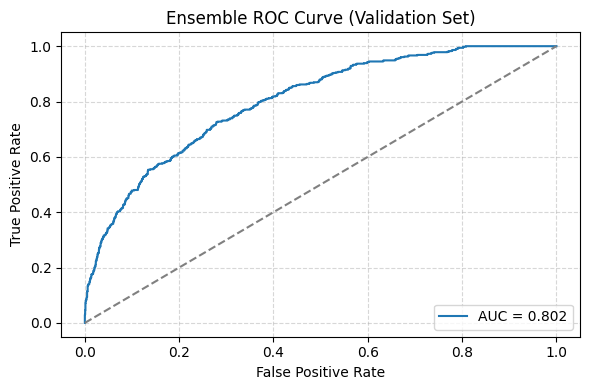

<Axes: >

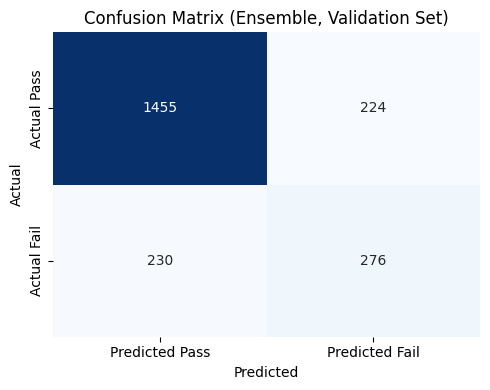

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

✅ TP vs FP classifier trained for two-stage classification.
✅ Final labels assigned: pass, conditional_pass, confident_fail


In [86]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, confusion_matrix,
    f1_score, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# === Ensure output directory exists ===
output_dir = '/content/drive/My Drive/msds434_project/images'
os.makedirs(output_dir, exist_ok=True)

# --- Train Logistic Regression ---
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)
val_probs_log = log_model.predict_proba(X_val)[:, 1]

# --- Train XGBoost ---
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
val_probs_xgb = xgb_model.predict_proba(X_val)[:, 1]

# --- Combine into Ensemble: average probabilities ---
ensemble_probs = (val_probs_log + val_probs_xgb) / 2

# === Optimize Threshold Using F1 Score ===
thresholds = np.arange(0.30, 0.70, 0.01)
f1_scores = [f1_score(y_val, (ensemble_probs >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"🎯 Optimal threshold (F1): {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.3f})")

# --- Final ensemble predictions at optimal threshold
ensemble_preds = (ensemble_probs >= best_threshold).astype(int)

# === Evaluate Ensemble Performance ===
print("✅ Ensemble Classification Report (Validation):")
print(classification_report(y_val, ensemble_preds))

ensemble_auc = roc_auc_score(y_val, ensemble_probs)
print(f"📈 AUC: {ensemble_auc:.3f}")

# === Save ROC Curve ===
fpr, tpr, _ = roc_curve(y_val, ensemble_probs)
_=plt.figure(figsize=(6, 4))
_=plt.plot(fpr, tpr, label=f"AUC = {ensemble_auc:.3f}")
_=plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('Ensemble ROC Curve (Validation Set)')
_=plt.legend(loc='lower right')
_=plt.grid(True, linestyle='--', alpha=0.5)
_=plt.tight_layout()
_=plt.savefig(os.path.join(output_dir, 'ensemble_roc_curve.png'), dpi=300)
plt.show()

# === Save Confusion Matrix ===
conf_mat = confusion_matrix(y_val, ensemble_preds)
_=plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Pass', 'Predicted Fail'],
            yticklabels=['Actual Pass', 'Actual Fail'])
_=plt.xlabel('Predicted')
_=plt.ylabel('Actual')
_=plt.title('Confusion Matrix (Ensemble, Validation Set)')
_=plt.tight_layout()
_=plt.savefig(os.path.join(output_dir, 'ensemble_confusion_matrix.png'), dpi=300)
plt.show()

# === Train TP-vs-FP Classifier for Second-Stage Decision Logic ===
fail_mask = (ensemble_preds == 1)
X_tp_fp = X_val[fail_mask].copy()
y_tp_fp = y_val[fail_mask].copy()

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_tp_fp, y_tp_fp, test_size=0.3, stratify=y_tp_fp, random_state=42
)

clf_tp_fp = LogisticRegression(max_iter=1000)
clf_tp_fp.fit(X_train_meta, y_train_meta)

print("✅ TP vs FP classifier trained for two-stage classification.")

# === Apply TP-vs-FP classifier to predicted fails ===
fail_indices = X_val[ensemble_preds == 1]
X_fails_only = X_val.loc[fail_indices.index]

# Predict probability of being a true fail
tp_probs = clf_tp_fp.predict_proba(X_fails_only)[:, 1]
confident_mask = tp_probs >= 0.5

# === Assign 3-class final labels ===
final_labels = pd.Series("pass", index=X_val.index)
final_labels.loc[X_fails_only.index[confident_mask]] = "confident_fail"
final_labels.loc[X_fails_only.index[~confident_mask]] = "marginal_fail"

# === Rename marginal_fail to conditional_pass ===
final_labels = final_labels.replace("marginal_fail", "conditional_pass")

print("✅ Final labels assigned: pass, conditional_pass, confident_fail")


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

Text(0.5, 1.0, 'Ensemble Model Performance (Validation Set)')

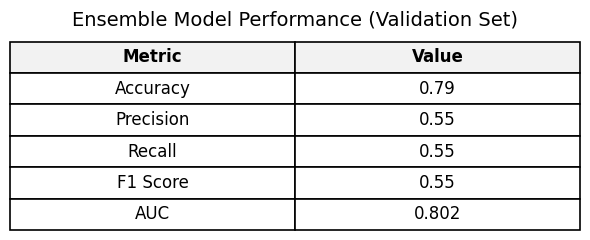

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Define Performance Metrics ===

metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    "Value": [0.790, 0.550, 0.550, 0.550, 0.802]
}

df_metrics = pd.DataFrame(metrics_data)

# === 2. Create Table Plot with Better Formatting ===
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis('off')

table = ax.table(
    cellText=df_metrics.values,
    colLabels=df_metrics.columns,
    loc='center',
    cellLoc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(12)

# Style header row
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.2)
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')

plt.title("Ensemble Model Performance (Validation Set)", fontsize=14, pad=12)
plt.tight_layout()

# === 3. Save to Google Drive ===
plt.savefig('/content/drive/My Drive/msds434_project/outputs/ensemble_metrics_table_clean.png', dpi=300)
plt.show()


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Rename marginal_fail to conditional_pass ===
final_labels = final_labels.replace("marginal_fail", "conditional_pass")

# === 1. Show ordered final decision breakdown ===
ordered_labels = ['pass', 'conditional_pass', 'confident_fail']
print("🧾 Final Decision Breakdown:")
print(final_labels.value_counts().reindex(ordered_labels))

# === 2. Create ordered breakdown of actual outcomes ===
result_df = pd.DataFrame({
    'decision': final_labels,
    'actual_fail': y_val
})

group_perf = (
    result_df
    .groupby('decision')['actual_fail']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .reindex(ordered_labels)
)

group_perf.columns = ['actual_pass', 'actual_fail']
print("📊 Proportion of Actual Outcomes by Decision Group:")
print(group_perf)




🧾 Final Decision Breakdown:
pass                1685
conditional_pass     237
confident_fail       263
Name: count, dtype: int64
📊 Proportion of Actual Outcomes by Decision Group:
                  actual_pass  actual_fail
decision                                  
pass                 0.863501     0.136499
conditional_pass     0.603376     0.396624
confident_fail       0.307985     0.692015


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

Text(0.5, 1.0, 'Tiered Decision Support Summary – Precision and Recall by Tier')

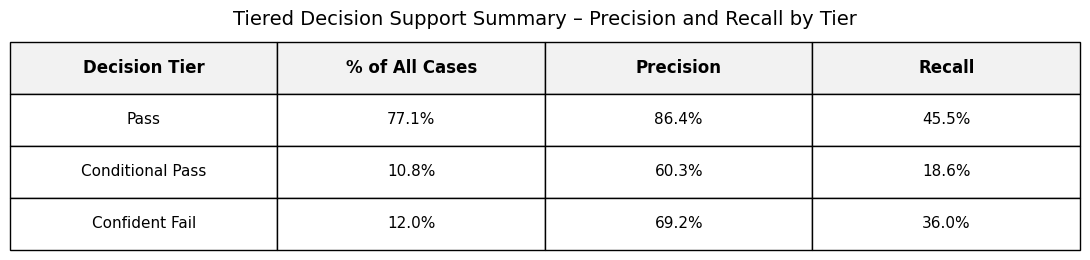

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# === Final numbers with 'Pass' at the top ===
data = [
    ["Pass",             "77.1%", "86.4%", "45.5%"],
    ["Conditional Pass", "10.8%", "60.3%", "18.6%"],
    ["Confident Fail",   "12.0%", "69.2%", "36.0%"]
]

columns = [
    "Decision Tier",
    "% of All Cases",
    "Precision",
    "Recall"
]

df = pd.DataFrame(data, columns=columns)

# === Create Table Plot ===
fig, ax = plt.subplots(figsize=(11, 2.7))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style header row
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.0)
    if row == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')

plt.title("Tiered Decision Support Summary – Precision and Recall by Tier", fontsize=14, pad=12)
plt.tight_layout()

# === Save or Show ===
plt.savefig('/content/drive/My Drive/msds434_project/outputs/tiered_decision_precision_recall_table.png', dpi=300)
plt.show()


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

Text(0.5, 0.9, 'Ensemble Model\n(Predicts Pass/Fail)')

Text(0.5, 0.7, 'Prediction = Fail?')

Text(0.25, 0.5, 'Final Decision:\nPass')

Text(0.75, 0.5, 'TP vs FP Classifier')

Text(0.63, 0.3, 'P(True Fail) ≥ 0.5')

Text(0.87, 0.3, 'P(True Fail) < 0.5')

Text(0.63, 0.1, 'Final Decision:\nConfident Fail')

Text(0.87, 0.1, 'Final Decision:\nMarginal Fail')

Text(0.5, 0.83, '')

Text(0.5, 0.66, '')

Text(0.5, 0.66, '')

Text(0.75, 0.46, '')

Text(0.75, 0.46, '')

Text(0.63, 0.26, '')

Text(0.87, 0.26, '')

Text(0.5, 1.0, 'Two-Stage Decision Support Flow')

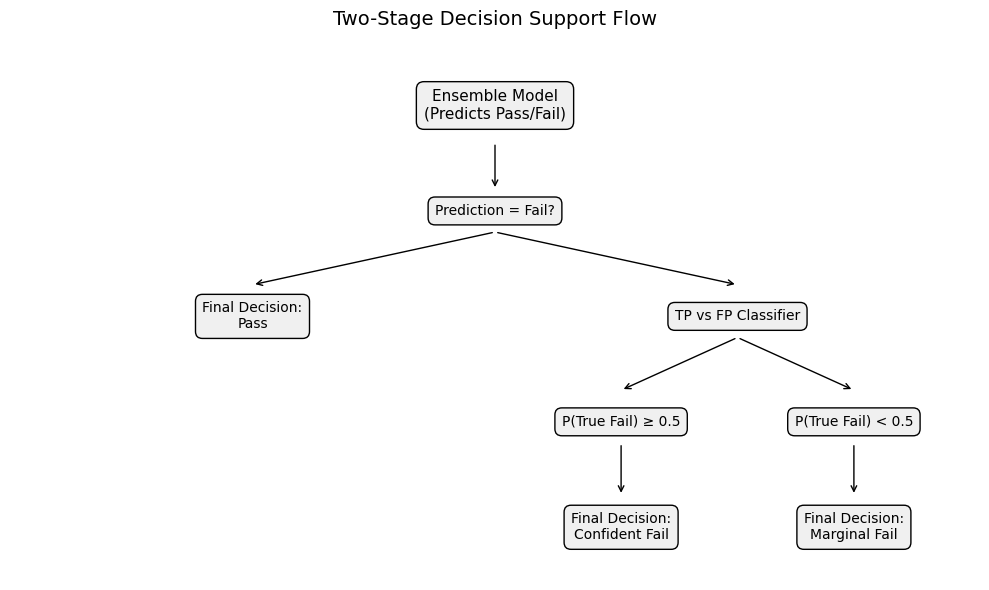

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Box style
box_style = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="#f0f0f0")

# === Nodes ===
ax.text(0.5, 0.9, "Ensemble Model\n(Predicts Pass/Fail)", ha='center', va='center', bbox=box_style, fontsize=11)
ax.text(0.5, 0.7, "Prediction = Fail?", ha='center', va='center', bbox=box_style, fontsize=10)
ax.text(0.25, 0.5, "Final Decision:\nPass", ha='center', va='center', bbox=box_style, fontsize=10)
ax.text(0.75, 0.5, "TP vs FP Classifier", ha='center', va='center', bbox=box_style, fontsize=10)
ax.text(0.63, 0.3, "P(True Fail) ≥ 0.5", ha='center', va='center', bbox=box_style, fontsize=10)
ax.text(0.87, 0.3, "P(True Fail) < 0.5", ha='center', va='center', bbox=box_style, fontsize=10)
ax.text(0.63, 0.1, "Final Decision:\nConfident Fail", ha='center', va='center', bbox=box_style, fontsize=10)
ax.text(0.87, 0.1, "Final Decision:\nMarginal Fail", ha='center', va='center', bbox=box_style, fontsize=10)

# === Arrows (corrected) ===
arrow = dict(arrowstyle="->")

ax.annotate("", xy=(0.5, 0.74), xytext=(0.5, 0.83), arrowprops=arrow)  # Ensemble → Fail?
ax.annotate("", xy=(0.25, 0.56), xytext=(0.5, 0.66), arrowprops=arrow)  # Fail? = No → Pass
ax.annotate("", xy=(0.75, 0.56), xytext=(0.5, 0.66), arrowprops=arrow)  # Fail? = Yes → Classifier

ax.annotate("", xy=(0.63, 0.36), xytext=(0.75, 0.46), arrowprops=arrow)  # Classifier → True Fail
ax.annotate("", xy=(0.87, 0.36), xytext=(0.75, 0.46), arrowprops=arrow)  # Classifier → False Fail

ax.annotate("", xy=(0.63, 0.16), xytext=(0.63, 0.26), arrowprops=arrow)  # → Confident
ax.annotate("", xy=(0.87, 0.16), xytext=(0.87, 0.26), arrowprops=arrow)  # → Marginal

# === Title and Save ===
plt.title("Two-Stage Decision Support Flow", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/two_stage_flowchart_corrected_arrows.png', dpi=300)
plt.show()


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

Text(0.01, 0.3, "If the model says [PASS], then about 9 out of 10 similar cases have historically passed. Action: issue 'pass'.")

Text(0.01, 0.24, 'If the model says [CONDITIONAL PASS], then about 3 out of 5 similar cases have historically passed. Action: review findings and judge appropriately.')

Text(0.01, 0.18, "If the model says [CONFIDENT FAIL], then about 2 out of 3 similar cases have historically failed. Action: issue 'fail'.")

Text(0.5, 1.0, 'Two-Stage Decision Logic Summary + Inspector Guidance')

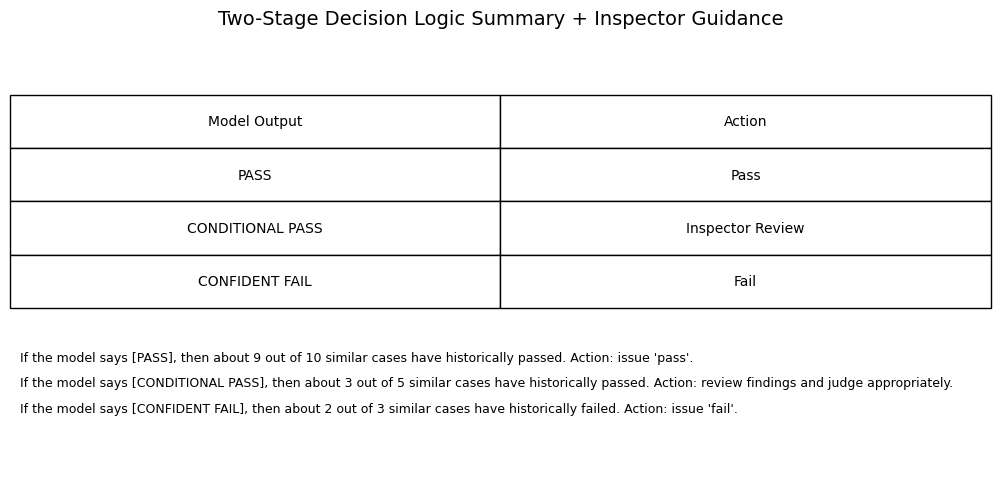

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Create Summary Table ===
data = [
    ["PASS", "Pass"],
    ["CONDITIONAL PASS", "Inspector Review"],
    ["CONFIDENT FAIL", "Fail"]
]

df = pd.DataFrame(data, columns=["Model Output", "Action"])

fig, ax = plt.subplots(figsize=(11, 5))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center',
    bbox=[0, 0.4, 1, 0.5]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# === 2. Add Inspector Guidance Without Emojis ===
statements = [
    "If the model says [PASS], then about 9 out of 10 similar cases have historically passed. Action: issue 'pass'.",
    "If the model says [CONDITIONAL PASS], then about 3 out of 5 similar cases have historically passed. Action: review findings and judge appropriately.",
    "If the model says [CONFIDENT FAIL], then about 2 out of 3 similar cases have historically failed. Action: issue 'fail'."
]

y_positions = [0.30, 0.24, 0.18]
for text, y in zip(statements, y_positions):
    ax.text(0.01, y, text, fontsize=9, va='top', ha='left', wrap=True)

plt.title("Two-Stage Decision Logic Summary + Inspector Guidance", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/two_stage_decision_with_guidance_no_emoji.png', dpi=300)
plt.show()



<Axes: >

Text(0.5, 1.0, 'AI Decision Distribution on Test Set')

Text(0, 0.5, 'Number of Inspections')

Text(0.5, 0, 'Predicted Class')

(array([0, 1, 2]),
 [Text(0, 0, 'pass'),
  Text(1, 0, 'conditional_pass'),
  Text(2, 0, 'confident_fail')])

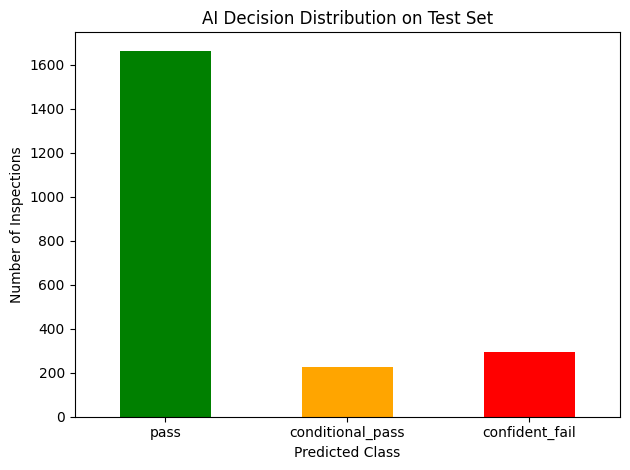

In [17]:
from sklearn.metrics import roc_auc_score

# === Step 1: Predict probabilities on the test set using both models ===
test_probs_log = log_model.predict_proba(X_test)[:, 1]
test_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# === Step 2: Ensemble prediction ===
ensemble_probs_test = (test_probs_log + test_probs_xgb) / 2
ensemble_preds_test = (ensemble_probs_test >= best_threshold).astype(int)

# === Step 3: Apply TP-vs-FP classifier to predicted fails ===
fail_indices_test = X_test[ensemble_preds_test == 1]
X_fails_only_test = X_test.loc[fail_indices_test.index]

# Get probability of being a true fail
tp_probs_test = clf_tp_fp.predict_proba(X_fails_only_test)[:, 1]

# === Step 4: Assign 3-class decision labels ===
final_labels_test = pd.Series("pass", index=X_test.index)
final_labels_test.loc[X_fails_only_test.index[tp_probs_test < 0.5]] = "conditional_pass"
final_labels_test.loc[X_fails_only_test.index[tp_probs_test >= 0.5]] = "confident_fail"


# Manually reorder the decision labels: pass, conditional_pass, confident_fail
ordered_labels = ['pass', 'conditional_pass', 'confident_fail']
label_counts = final_labels_test.value_counts().reindex(ordered_labels)

# Plot with custom order
label_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("AI Decision Distribution on Test Set")
plt.ylabel("Number of Inspections")
plt.xlabel("Predicted Class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/decision_distribution.png')
plt.show()







<Axes: xlabel='decision'>

Text(0.5, 1.0, 'Actual Outcomes by AI Decision Group')

Text(0, 0.5, 'Proportion of Inspections')

Text(0.5, 0, 'Predicted Class')

(array([0, 1, 2]),
 [Text(0, 0, 'pass'),
  Text(1, 0, 'conditional_pass'),
  Text(2, 0, 'confident_fail')])

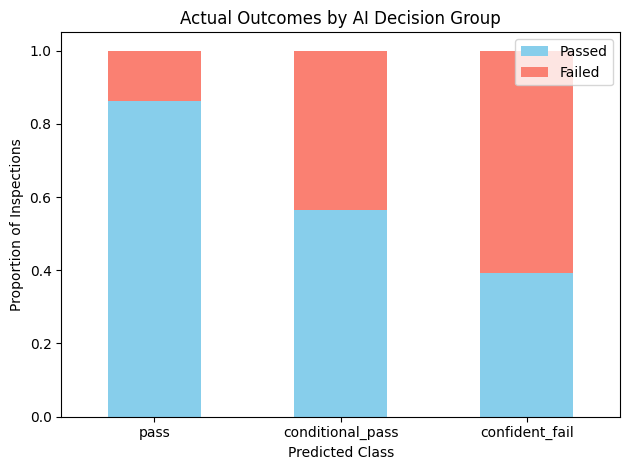

In [19]:
# Create a DataFrame combining predictions and actual outcomes
result_df_test = pd.DataFrame({
    'decision': final_labels_test,
    'actual_fail': y_test
})

# Compute pass/fail proportions for each predicted tier
group_perf_test = (
    result_df_test
    .groupby('decision')['actual_fail']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .reindex(['pass', 'conditional_pass', 'confident_fail'])  # keep order consistent
)

group_perf_test.columns = ['actual_pass', 'actual_fail']



group_perf_test.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title("Actual Outcomes by AI Decision Group")
plt.ylabel("Proportion of Inspections")
plt.xlabel("Predicted Class")
plt.legend(["Passed", "Failed"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/outcomes_by_decision_group.png')
plt.show()


Text(0.5, 1.0, 'Precision-Recall Curve')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

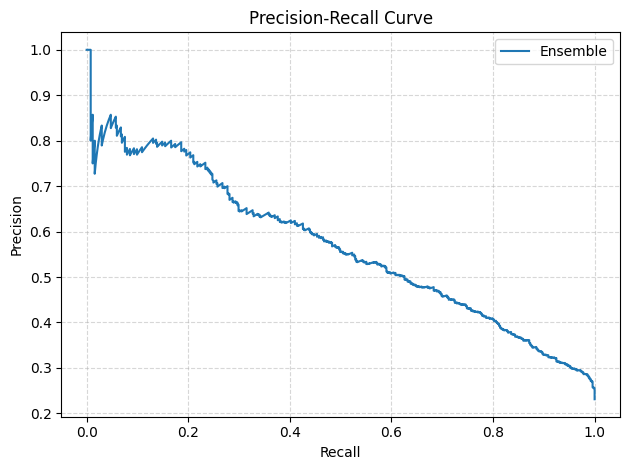

In [20]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, ensemble_probs_test)
plt.plot(rec, prec, label='Ensemble')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/precision_recall_curve.png')
plt.show()


<Axes: >

Text(0.5, 1.0, 'Top 10 Logistic Regression Features')

Text(0.5, 0, 'Absolute Coefficient')

<Axes: >

Text(0.5, 1.0, 'Top 10 XGBoost Features')

Text(0.5, 0, 'Feature Importance')

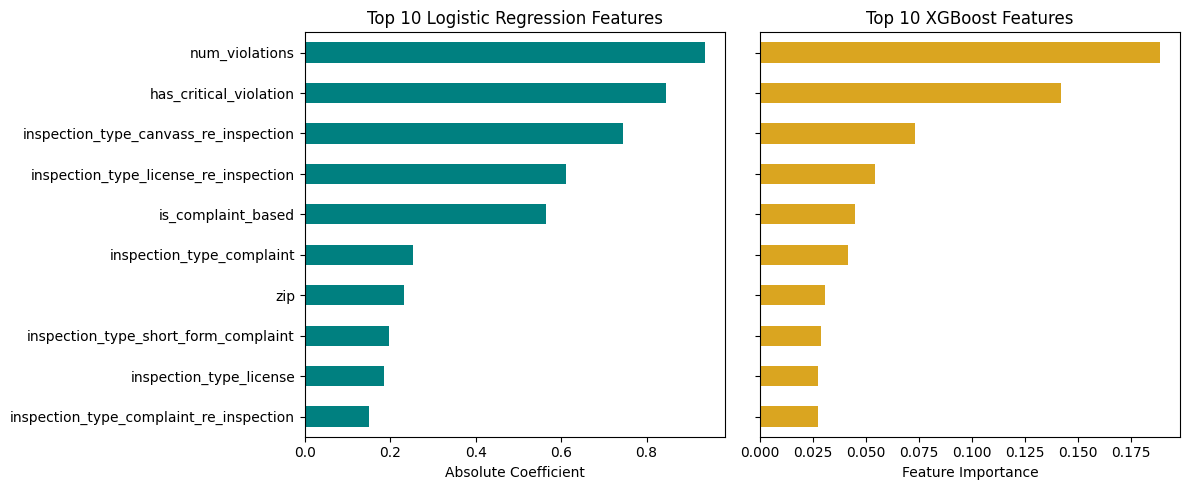

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Logistic Regression Feature Importances (absolute coefficient)
log_importance = pd.Series(
    log_model.coef_[0],
    index=X_train.columns
).abs().sort_values(ascending=False).head(10)

# --- XGBoost Feature Importances (built-in gain metric)
xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(10)

# --- Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

log_importance.sort_values().plot.barh(ax=axs[0], color='teal')
axs[0].set_title('Top 10 Logistic Regression Features')
axs[0].set_xlabel('Absolute Coefficient')

xgb_importance.sort_values().plot.barh(ax=axs[1], color='goldenrod')
axs[1].set_title('Top 10 XGBoost Features')
axs[1].set_xlabel('Feature Importance')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/ensemble_feature_importance.png')
plt.show()


Text(0.5, 1.0, 'SHAP Summary Plot: XGBoost Model (Test Set)')

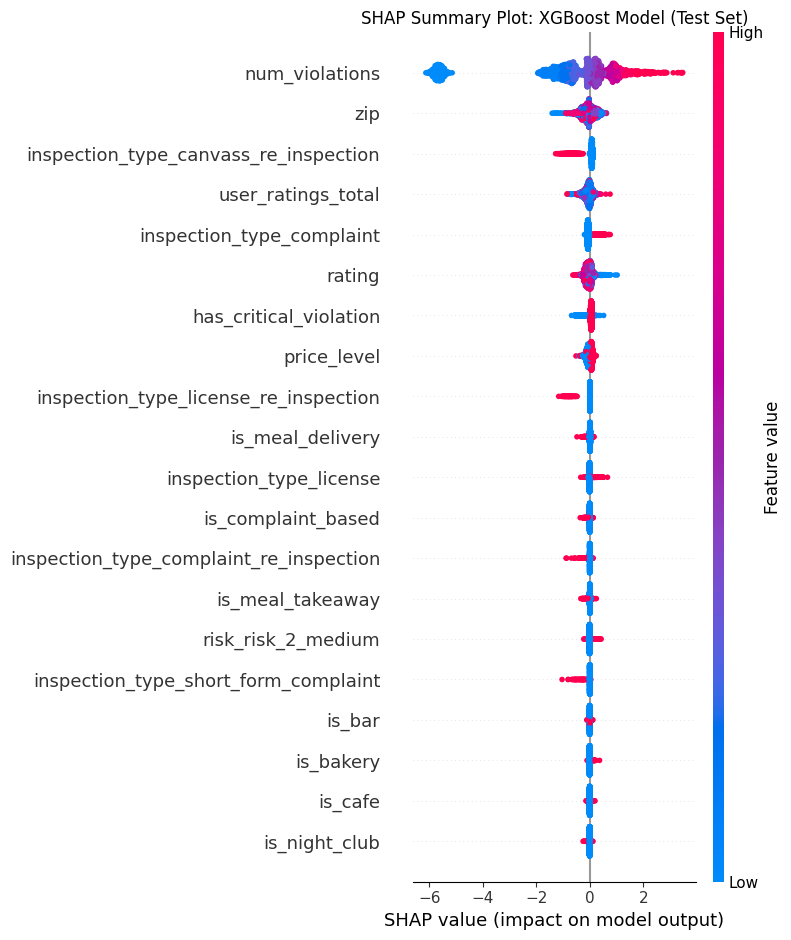

In [22]:
import shap

# 1. Create SHAP explainer for the trained XGBoost model
explainer = shap.Explainer(xgb_model)

# 2. Compute SHAP values on the validation or test set
shap_values = explainer(X_test)

# 3. Summary plot: feature impact across entire test set
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot: XGBoost Model (Test Set)")
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/shap_summary_xgb.png')
plt.show()


<Figure size 800x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Top Features: TP vs FP Classifier')

Text(0.5, 0, 'Coefficient (Logistic Regression)')

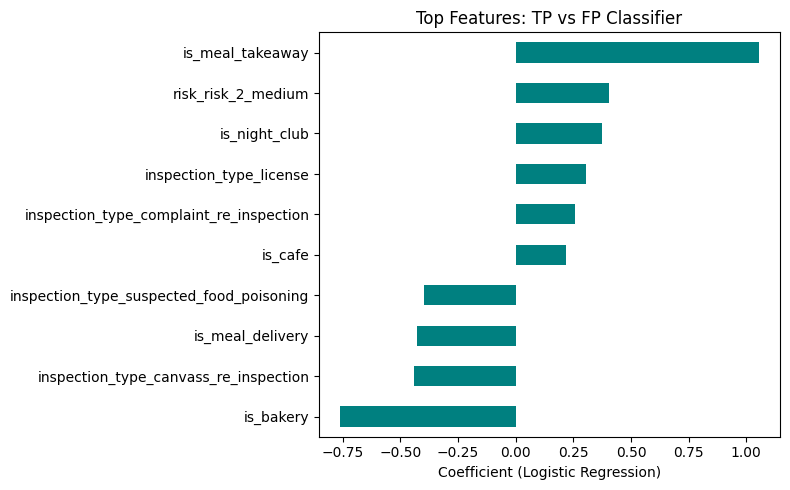

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Get top 10 features (already trained clf_tp_fp)
feature_importance = pd.Series(clf_tp_fp.coef_[0], index=X_tp_fp.columns)
top_features = feature_importance.sort_values(key=abs, ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 5))
top_features.sort_values().plot(kind='barh', color='teal')
plt.title("Top Features: TP vs FP Classifier")
plt.xlabel("Coefficient (Logistic Regression)")
plt.tight_layout()
plt.savefig('/content/drive/My Drive/msds434_project/outputs/tp_fp_feature_importance.png')
plt.show()


<Figure size 500x400 with 0 Axes>

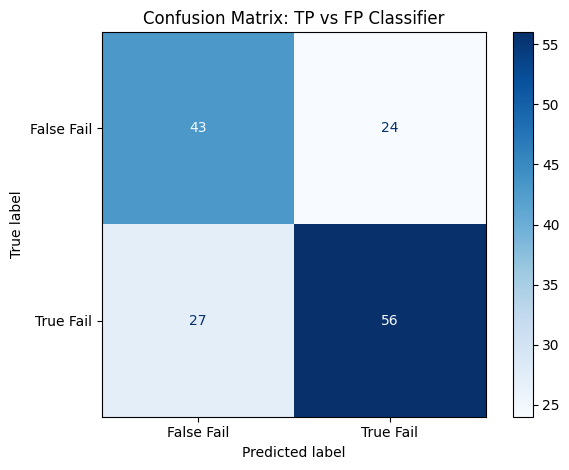

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test portion of TP vs FP dataset
y_pred_meta = clf_tp_fp.predict(X_test_meta)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test_meta, y_pred_meta)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False Fail', 'True Fail'])

_ = plt.figure(figsize=(5, 4))
_ = disp.plot(cmap='Blues', values_format='d')
_ = plt.title("Confusion Matrix: TP vs FP Classifier")
_ = plt.tight_layout()
_ = plt.savefig('/content/drive/My Drive/msds434_project/outputs/tp_fp_confusion_matrix.png')
_ = plt.show()


In [25]:
import joblib
import os

# Define model save path
model_dir = '/content/drive/My Drive/msds434_project/models'
os.makedirs(model_dir, exist_ok=True)

# Save each model
joblib.dump(log_model, os.path.join(model_dir, 'logistic_model.pkl'))
joblib.dump(xgb_model, os.path.join(model_dir, 'xgboost_model.pkl'))
joblib.dump(clf_tp_fp, os.path.join(model_dir, 'tp_fp_classifier.pkl'))

print("✅ Models saved to Google Drive.")


['/content/drive/My Drive/msds434_project/models/logistic_model.pkl']

['/content/drive/My Drive/msds434_project/models/xgboost_model.pkl']

['/content/drive/My Drive/msds434_project/models/tp_fp_classifier.pkl']

✅ Models saved to Google Drive.


In [28]:
import os
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

# === 1. Authenticate to GCP ===
auth.authenticate_user()
bq_client = bigquery.Client(project='hygiene-prediction-434')

# === 2. Rejoin inspection_id, X, and y ===

# Ensure y is a Series before concatenating
if not isinstance(y, pd.Series):
    y = pd.Series(y, index=X.index, name='fail')

# Combine for final training DataFrame
df_final_training = pd.concat([inspection_ids, X, y], axis=1)

# === 3. Clean column names to be BigQuery-compliant ===
df_final_training.columns = (
    df_final_training.columns
    .str.replace(r"[()\s-]", "_", regex=True)
    .str.replace(r"__+", "_", regex=True)
    .str.strip("_")
    .str.lower()
)

# === 4. Save locally as CSV ===
os.makedirs('/content', exist_ok=True)
csv_path = '/content/Training_Data_Inspection_Classification_Final.csv'
df_final_training.to_csv(csv_path, index=False)
print(f"✅ CSV saved at: {csv_path}")

# === 5. Define BQ destination ===
table_ref = 'hygiene-prediction-434.RestaurantModeling.Training_Data_Inspection_Classification_Final'

# === 6. Configure upload job ===
# Configure upload job (overwrite mode)
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,
    write_disposition="WRITE_TRUNCATE"  # 👈 overwrite existing table
)

# === 7. Upload to BigQuery ===
with open(csv_path, 'rb') as file:
    load_job = bq_client.load_table_from_file(file, table_ref, job_config=job_config)

load_job.result()  # Wait for job to complete

print(f"✅ Uploaded to BigQuery: {table_ref}")


✅ CSV saved at: /content/Training_Data_Inspection_Classification_Final.csv


LoadJob<project=hygiene-prediction-434, location=US, id=5948ed9f-47c7-4d2f-8569-9d0a938b2da4>

✅ Uploaded to BigQuery: hygiene-prediction-434.RestaurantModeling.Training_Data_Inspection_Classification_Final


## **Load model and run pipeline**

In [34]:
log_model = joblib.load('/content/drive/My Drive/msds434_project/models/logistic_model.pkl')
xgb_model = joblib.load('/content/drive/My Drive/msds434_project/models/xgboost_model.pkl')
clf_tp_fp = joblib.load('/content/drive/My Drive/msds434_project/models/tp_fp_classifier.pkl')


In [46]:
import os
import joblib
import pandas as pd
import numpy as np
import random
from google.colab import auth
from google.cloud import bigquery

# === 1. Authenticate and connect to BigQuery ===
auth.authenticate_user()
bq_client = bigquery.Client(project='hygiene-prediction-434')

# === 2. Load trained models from Google Drive ===
model_path = '/content/drive/My Drive/msds434_project/models'
log_model = joblib.load(os.path.join(model_path, 'logistic_model.pkl'))
xgb_model = joblib.load(os.path.join(model_path, 'xgboost_model.pkl'))
clf_tp_fp = joblib.load(os.path.join(model_path, 'tp_fp_classifier.pkl'))
print("✅ Models loaded successfully.")

# === 3. Pull a list of all inspection_ids from TrainingData ===
query_ids = """
SELECT DISTINCT CAST(inspection_id AS STRING) AS inspection_id
FROM `hygiene-prediction-434.RestaurantModeling.TrainingData`
"""
df_ids = bq_client.query(query_ids).to_dataframe()
all_inspection_ids = df_ids['inspection_id'].tolist()

# === 4. Sample 10 random inspection_ids (seeded for reproducibility) ===
random.seed(42)
sampled_ids = random.sample(all_inspection_ids, 10)
inspection_ids_str = ', '.join([f"CAST('{id}' AS INT64)" for id in sampled_ids])

# === 5. Query model-ready features ===
query_features = f"""
SELECT *
FROM `hygiene-prediction-434.RestaurantModeling.Training_Data_Inspection_Classification_Final`
WHERE inspection_id IN ({inspection_ids_str})
"""
df_features = bq_client.query(query_features).to_dataframe()
print(f"✅ Loaded {df_features.shape[0]} rows of features for prediction.")

# === 6. Extract label and ID, and prep feature matrix ===
y_sample = df_features['fail'].reset_index(drop=True)
inspection_ids = df_features['inspection_id'].reset_index(drop=True)
X_sample = df_features.drop(columns=['fail', 'inspection_id']).copy().reset_index(drop=True)

# === 7. Rename and reorder columns to match model expectations ===
original_names = list(log_model.feature_names_in_)
cleaned_names = [col.replace(" ", "_").replace("(", "").replace(")", "").replace("__", "_") for col in original_names]
column_name_map = dict(zip(cleaned_names, original_names))
X_sample = X_sample.rename(columns=column_name_map)
X_sample = X_sample[original_names]
print("✅ Feature matrix aligned with model inputs.")

# === 8. Define best threshold (from validation phase) ===
best_threshold = 0.25  # ← Replace with your best threshold

# === 9. Ensemble prediction ===
probs_log = log_model.predict_proba(X_sample)[:, 1]
probs_xgb = xgb_model.predict_proba(X_sample)[:, 1]
ensemble_probs_sample = (probs_log + probs_xgb) / 2
ensemble_preds_sample = (ensemble_probs_sample >= best_threshold).astype(int)

# === 10. Second-stage classification (TP vs FP) ===
X_fails_only_sample = X_sample[ensemble_preds_sample == 1]
tp_probs_sample = clf_tp_fp.predict_proba(X_fails_only_sample)[:, 1]
confident_mask = tp_probs_sample >= 0.5
marginal_mask = ~confident_mask

# === 11. Assign final labels ===
final_pred_labels = pd.Series("pass", index=X_sample.index)
final_pred_labels.loc[X_fails_only_sample.index[confident_mask]] = "confident_fail"
final_pred_labels.loc[X_fails_only_sample.index[marginal_mask]] = "marginal_fail"
print("✅ Model predictions complete.")

# === 12. Query metadata for sampled inspections (deduplicated) ===
query_metadata = f"""
WITH deduped_training_data AS (
  SELECT *
  FROM (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY inspection_id ORDER BY RAND()) AS rn
    FROM `hygiene-prediction-434.RestaurantModeling.TrainingData`
    WHERE inspection_id IN UNNEST([{', '.join([f"'{id}'" for id in sampled_ids])}])
  )
  WHERE rn = 1
)
SELECT
  td.inspection_id,
  td.violation_codes,
  td.dba_name,
  rp.matched_name,
  rp.address,
  rp.zip
FROM deduped_training_data td
LEFT JOIN `hygiene-prediction-434.RestaurantModeling.RestaurantProfile` rp
  ON td.dba_name = rp.dba_name
"""
df_metadata = bq_client.query(query_metadata).to_dataframe()
print(f"✅ Retrieved metadata for {df_metadata.shape[0]} inspections.")

# === 13. Create predictions dataframe and merge ===
predictions_df = pd.DataFrame({
    'inspection_id': df_features['inspection_id'].astype(str),
    'model_prediction': final_pred_labels,
    'ensemble_score': ensemble_probs_sample,
    'num_violations': df_features['num_violations'],
    'rating': df_features['rating'],
    'price_level': df_features['price_level']
})

df_metadata['inspection_id'] = df_metadata['inspection_id'].astype(str)

output_df = pd.merge(predictions_df, df_metadata, on='inspection_id', how='left')

# === 14. Clean label names and reorder columns ===
output_df['model_prediction'] = output_df['model_prediction'].replace('marginal_fail', 'conditional_pass')

desired_order = [
    'inspection_id',
    'matched_name',
    'address',
    'zip',
    'rating',
    'price_level',
    'violation_codes',
    'num_violations',
    'ensemble_score',
    'model_prediction'
]
output_df = output_df[desired_order]

# === 15. Display final results ===
print("✅ Final predictions complete.")
output_df


✅ Models loaded successfully.
✅ Loaded 10 rows of features for prediction.
✅ Feature matrix aligned with model inputs.
✅ Model predictions complete.
✅ Retrieved metadata for 14 inspections.
✅ Final predictions complete.


,inspection_id,matched_name,address,zip,rating,price_level,violation_codes,num_violations,ensemble_score,model_prediction
0,2562447,5 Rabanitos Restaurante & Taqueria,1758 W 18th St,60608,4.5,2,"[37, 38, 53]",3,0.500110,conditional_pass
1,2522142,Tamaleria Roman,5054 W Armitage Ave,60639,3.5,2,"[3, 5, 10, 48, 55, 55, 56, 57, 60, 61]",10,0.817203,confident_fail
2,2600290,Wen Cai Chinese Kitchen,2334 W Cermak Rd,60608,4.7,1,"[23, 37, 38, 43, 45, 49, 55]",7,0.634512,conditional_pass
3,2576096,Sushi Hall,2630 N Clark St,60614,4.7,2,"[25, 49, 57, 60]",4,0.442154,conditional_pass
4,2593868,Uncle Remus SFC - Central & Madison,5611 W Madison St,60644,4.0,2,"[2, 37, 38, 38, 47, 49, 53, 56, 57]",9,0.741772,conditional_pass
5,2596995,Pizza Hut,3009 N Clark St,60657,3.5,1,"[2, 55, 57]",3,0.289084,conditional_pass
6,2596995,Pizza Hut,2042 W 47th St,60609,3.5,1,"[2, 55, 57]",3,0.289084,conditional_pass
7,2596995,Pizza Hut,11708 S Marshfield Ave,11708,3.5,1,"[2, 55, 57]",3,0.289084,conditional_pass
8,2596995,Pizza Hut,4350 S Pulaski Rd,60632,3.5,1,"[2, 55, 57]",3,0.289084,conditional_pass
9,2596995,Pizza Hut,3045 N Pulaski Rd,60641,3.5,1,"[2, 55, 57]",3,0.289084,conditional_pass


In [89]:
def generate_inspection_report(inspector_id: int, seed: int = 42, sample_size: int = 10):
    import os
    from io import BytesIO
    import joblib
    import pandas as pd
    import numpy as np
    import random
    from datetime import datetime
    from google.colab import auth
    from google.cloud import bigquery, storage

    # === 1. Authenticate and connect ===
    auth.authenticate_user()
    bq_client = bigquery.Client(project='hygiene-prediction-434')
    gcs_client = storage.Client(project='hygiene-prediction-434')
    bucket_name = 'restaurant-risk-reports'

    # === 2. Load trained models from GCS ===
    model_bucket = gcs_client.bucket('ml-prediction-models')

    def load_model_from_gcs(blob_name):
        blob = model_bucket.blob(blob_name)
        model_bytes = blob.download_as_bytes()
        return joblib.load(BytesIO(model_bytes))

    log_model = load_model_from_gcs('logistic_model.pkl')
    xgb_model = load_model_from_gcs('xgboost_model.pkl')
    clf_tp_fp = load_model_from_gcs('tp_fp_classifier.pkl')

    print("✅ Models loaded successfully from GCS.")

    # === 3. Sample inspection_ids ===
    query_ids = f"""
    SELECT *
    FROM `hygiene-prediction-434.RestaurantModeling.Training_Data_Inspection_Classification_Final`
    ORDER BY RAND()
    LIMIT {sample_size}
    """

    df_ids = bq_client.query(query_ids).to_dataframe()
    all_inspection_ids = df_ids['inspection_id'].tolist()

    random.seed(seed)
    sampled_ids = random.sample(all_inspection_ids, sample_size)
    inspection_ids_str = ', '.join([f"CAST('{id}' AS INT64)" for id in sampled_ids])

    # === 4. Load features ===
    query_features = f"""
    SELECT *
    FROM `hygiene-prediction-434.RestaurantModeling.Training_Data_Inspection_Classification_Final`
    WHERE inspection_id IN ({inspection_ids_str})
    """
    df_features = bq_client.query(query_features).to_dataframe()
    print(f"✅ Loaded {df_features.shape[0]} rows of features for prediction.")

    y_sample = df_features['fail'].reset_index(drop=True)
    inspection_ids = df_features['inspection_id'].reset_index(drop=True)
    X_sample = df_features.drop(columns=['fail', 'inspection_id']).copy().reset_index(drop=True)

    original_names = list(log_model.feature_names_in_)
    cleaned_names = [col.replace(" ", "_").replace("(", "").replace(")", "").replace("__", "_") for col in original_names]
    column_name_map = dict(zip(cleaned_names, original_names))
    X_sample = X_sample.rename(columns=column_name_map)
    X_sample = X_sample[original_names]
    print("✅ Feature matrix aligned with model inputs.")

    # === 5. Predictions ===
    best_threshold = 0.25
    probs_log = log_model.predict_proba(X_sample)[:, 1]
    probs_xgb = xgb_model.predict_proba(X_sample)[:, 1]
    ensemble_probs_sample = (probs_log + probs_xgb) / 2
    ensemble_preds_sample = (ensemble_probs_sample >= best_threshold).astype(int)

    X_fails_only_sample = X_sample[ensemble_preds_sample == 1]
    tp_probs_sample = clf_tp_fp.predict_proba(X_fails_only_sample)[:, 1]
    confident_mask = tp_probs_sample >= 0.5
    marginal_mask = ~confident_mask

    final_pred_labels = pd.Series("pass", index=X_sample.index)
    final_pred_labels.loc[X_fails_only_sample.index[confident_mask]] = "confident_fail"
    final_pred_labels.loc[X_fails_only_sample.index[marginal_mask]] = "marginal_fail"
    print("✅ Model predictions complete.")

    # === 6. Metadata Query ===
    inspection_ids_formatted = ", ".join(f"'{id}'" for id in inspection_ids)

    query_metadata = f"""
    WITH deduped_training_data AS (
      SELECT *
      FROM (
        SELECT *,
              ROW_NUMBER() OVER (PARTITION BY inspection_id ORDER BY RAND()) AS rn
        FROM `hygiene-prediction-434.RestaurantModeling.TrainingData`
        WHERE CAST(inspection_id AS STRING) IN UNNEST([{inspection_ids_formatted}])
      )
      WHERE rn = 1
    ),
    deduped_restaurant_profile AS (
      SELECT *
      FROM (
        SELECT *,
              ROW_NUMBER() OVER (PARTITION BY dba_name ORDER BY RAND()) AS rn
        FROM `hygiene-prediction-434.RestaurantModeling.RestaurantProfile`
      )
      WHERE rn = 1
    )
    SELECT
      td.inspection_id,
      td.violation_codes,
      td.dba_name,
      rp.matched_name,
      rp.address,
      rp.zip
    FROM deduped_training_data td
    LEFT JOIN deduped_restaurant_profile rp
      ON td.dba_name = rp.dba_name
    """

    df_metadata = bq_client.query(query_metadata).to_dataframe()
    print(f"✅ Retrieved metadata for {df_metadata.shape[0]} inspections.")

    # === 7. Assemble final output ===
    predictions_df = pd.DataFrame({
        'inspection_id': df_features['inspection_id'].astype(str),
        'model_prediction': final_pred_labels,
        'ensemble_score': ensemble_probs_sample,
        'num_violations': df_features['num_violations'],
        'critical_viol': df_features['has_critical_violation'],
        'rating': df_features['rating'],
        'price_level': df_features['price_level']
    })

    df_metadata['inspection_id'] = df_metadata['inspection_id'].astype(str)
    output_df = pd.merge(predictions_df, df_metadata, on='inspection_id', how='left')
    output_df['model_prediction'] = output_df['model_prediction'].replace('marginal_fail', 'conditional_pass')

    desired_order = [
        'inspection_id',
        'matched_name',
        'address',
        'zip',
        'rating',
        'price_level',
        'violation_codes',
        'critical_viol',
        'num_violations',
        'model_prediction'
    ]
    output_df = output_df[desired_order]

    print("✅ Final report built.")

    # === Clean violation_codes BEFORE sorting or saving ===
    def format_violation_codes(val):
        # Handle NaN or empty list
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return ""

        # Convert arrays/lists to list of strings
        if isinstance(val, (list, np.ndarray)):
            return ", ".join(str(code) for code in val)

        # Handle string representations like "['55' '57']"
        codes = re.findall(r'\d+', str(val))
        return ", ".join(codes)

    output_df['violation_codes'] = output_df['violation_codes'].apply(format_violation_codes)

    # === Then sort by model_prediction ===
    prediction_order = ['confident_fail', 'conditional_pass', 'pass']
    output_df['model_prediction'] = pd.Categorical(
        output_df['model_prediction'],
        categories=prediction_order,
        ordered=True
    )
    output_df = output_df.sort_values(by='model_prediction').reset_index(drop=True)


    # === 9. Save CSV directly to GCS ===
    from io import StringIO
    today_str = datetime.today().strftime("%m-%d-%Y")
    file_name = f"risk_report_I{inspector_id}_{today_str}_{seed}.csv"

    # Convert DataFrame to CSV in memory
    csv_buffer = StringIO()
    output_df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    # Upload to GCS
    bucket = gcs_client.bucket(bucket_name)
    blob = bucket.blob(file_name)
    blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

    gcs_uri = f"gs://{bucket_name}/{file_name}"
    print(f"✅ Report uploaded to GCS: {gcs_uri}")
    return output_df, gcs_uri


def main():
    import os
    import yaml

    input_file = os.path.join(os.path.dirname(__file__), "risk_report_inputs.yaml")

    # Read the input YAML file
    with open(input_file, "r") as f:
        params = yaml.safe_load(f)

    # Extract parameters from config
    inspector_id = int(params.get("inspector_id"))
    sample_size = int(params.get("sample_size", 100))
    seed = int(params.get("seed", 42))

    print(f"🚀 Starting inspection report for Inspector {inspector_id} using seed {seed} with {sample_size} rows")

    df, gcs_uri = generate_inspection_report(
        inspector_id=inspector_id,
        seed=seed,
        sample_size=sample_size
    )

    print("✅ Report generation complete.")
    print(f"📄 Report saved to: {gcs_uri}")


if __name__ == "__main__":
    main()





In [90]:
df, uri = generate_inspection_report(inspector_id=25, seed=50, sample_size=100)
print("GCS URI:", uri)



✅ Models loaded successfully from GCS.
✅ Loaded 100 rows of features for prediction.
✅ Feature matrix aligned with model inputs.
✅ Model predictions complete.
✅ Retrieved metadata for 100 inspections.
✅ Final report built.
✅ Report uploaded to GCS: gs://restaurant-risk-reports/risk_report_I25_05-14-2025_50.csv
GCS URI: gs://restaurant-risk-reports/risk_report_I25_05-14-2025_50.csv
